# Detecting Sleep States solution using 1D Convolutional Neural Network

<a target="_blank" href="https://colab.research.google.com/github/greentea-ai/DetectSleepStates/blob/main/main_cpd.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Preparation

`is_submission`: whether the notebook is run as a submission to the Kaggle competition. If run as a submission, the notebook uses the original Kaggle dataset.

In [1]:
is_submission = False

In [2]:
if is_submission:
    data_root = '/kaggle/input/child-mind-institute-detect-sleep-states'

### Downloading the dataset

In case we are not doing a submission, we download a dataset a testing dataset generated from the original data, which is split to 247 training series and 30 testing series for local evaluation.

In [ ]:
def download_data():
  !mkdir data
  !wget -nc -O data/train_events.csv "https://www.dropbox.com/scl/fi/zo7q4t5bhlakuxoh6a4ys/train_events.csv?rlkey=zbcvut5w2zsw0pdo5jliyokg9&dl=0"
  !wget -nc -O data/train_series.parquet "https://www.dropbox.com/scl/fi/xqvzofoos3nty3m0lsvr2/train_series.parquet?rlkey=g0cd8cymbjrve9wy06213un36&dl=0"
  !wget -nc -O data/test_events.csv "https://www.dropbox.com/scl/fi/pqqxr3kwxp11n4hnsqs6o/test_events.csv?rlkey=uej32itkf7cx16ykvxwfgcs4h&dl=0"
  !wget -nc -O data/test_series.parquet "https://www.dropbox.com/scl/fi/cifdom9qg3ui0gtiznfi0/test_series.parquet?rlkey=caj8avqzwzv42l4bfb6ucjjjw&dl=0"

if not is_submission:
  download_data()
  data_root = 'data'

### Imported libraries

- os: to handle file system paths
- gc: garbage collector to free up space mid-run
- pandas: data analysis
- numpy: math and array operations
- matplotlib: plotting data
- scikit-learn: data preprocessing
- tensorflow: model creation

In [4]:
! pip -q install pandas numpy matplotlib scikit-learn tensorflow

In [5]:
from os import path
import gc
import pandas as pd
import numpy as np

## Creating the training dataset

### Reading the training events

train_events: contains the data from train_events.csv, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **night (int)**: nth night in a given series
- **event (str)**: either onset or wakeup
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval

series_list: all the unique series_ids in one list

In [6]:
train_events = pd.read_csv(
    path.join(data_root, 'train_events.csv'),
    dtype={
        'series_id': 'str',
        'night': 'Int32',
        'event': 'str',
        'step': 'Int64',
    }
)
series_list = train_events['series_id'].unique()
print(len(series_list))

247



### Preprocessing the training events

Drop events without time information. This is necessary as an event without time information means there was no sleep recorded for the given night.

In [7]:
train_events = train_events.dropna(axis=0)
train_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8525 entries, 0 to 12965
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8525 non-null   int64 
 1   series_id   8525 non-null   object
 2   night       8525 non-null   Int32 
 3   event       8525 non-null   object
 4   step        8525 non-null   Int64 
 5   timestamp   8525 non-null   object
dtypes: Int32(1), Int64(1), int64(1), object(3)
memory usage: 449.6+ KB


#### Filtering out invalid nights

An invalid night is a night where either the onset or wakeup time is missing.

In [8]:
bad_nights = train_events[['series_id', 'night', 'event']].groupby(by=['series_id', 'night']).count()
bad_nights = bad_nights[bad_nights['event']!=2].reset_index()
print(bad_nights)

      series_id  night  event
0  0ce74d6d2106     20      1
1  154fe824ed87     30      1
2  44a41bba1ee7     10      1
3  efbfc4526d58      7      1
4  f8a8da8bdd00     17      1


In [9]:
bad_series = bad_nights['series_id'].unique()

In [10]:
print(bad_series)

['0ce74d6d2106' '154fe824ed87' '44a41bba1ee7' 'efbfc4526d58'
 'f8a8da8bdd00']


In [11]:
train_events = train_events[~(train_events['series_id'].isin(bad_series))]

In [12]:
series_list = train_events['series_id'].unique()
print(series_list[:10])
print(len(series_list))

['038441c925bb' '03d92c9f6f8a' '0402a003dae9' '04f547b8017d'
 '062cae666e2a' '062dbd4c95e6' '08db4255286f' '0a96f4993bd7'
 '0cd1e3d0ed95' '0cfc06c129cc']
234


### Reading the training time series

train_series: contains the data from train_series.parquet, this includes:
- **series_id (str)**: id of a series corresponding to a person's readings
- **anglez (float)**: z-angle is a metric that refers to the angle of the arm relative to the vertical axis of the body
- **enmo (float)**: Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero

not included:
- **step (int)**: there is 1 reading in the train_series every 5 seconds, 1 step is this interval
- **timestamp (timestamp)**: the time of the reading
we do not need time information as there is no causation between sleep state changes and time

In [13]:
train_series = pd.read_parquet(path.join(data_root, 'train_series.parquet'), columns=['series_id', 'anglez', 'enmo'])

### Preprocessing the time series

Using the **StandardScaler** from sklearn.preprocessing we can easily standardize our dataset to have the properties:
- mean = 0
- std = 1

In [14]:
train_series.describe([])

anglez          enmo
count  1.144156e+08  1.144156e+08
mean  -8.855578e+00  4.143985e-02
std    3.539915e+01  1.024321e-01
min   -9.000000e+01  0.000000e+00
50%   -9.570600e+00  1.720000e-02
max    9.000000e+01  1.143370e+01

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
input_scaler = scaler.fit(train_series[['anglez', 'enmo']])
train_series[['anglez', 'enmo']] = scaler.transform(train_series[['anglez', 'enmo']])

In [16]:
train_series.describe([])

anglez          enmo
count  1.144156e+08  1.144156e+08
mean   3.548946e-08  8.316777e-09
std    1.000000e+00  1.000000e+00
min   -2.292271e+00 -4.045592e-01
50%   -2.019970e-02 -2.366430e-01
max    2.792597e+00  1.112177e+02

### Creating maps by series IDs
Then we break up the `train_series` and `train_events` by series ids.

- `event_map`:
Map of event dataframes by ids
- `series_map`:
Map of series dataframes by ids

In [17]:
event_map = {}
for series_id, events in train_events.groupby('series_id'):
    event_map[series_id] = events.drop(columns=['series_id', 'timestamp']).reset_index(drop=True)

In [18]:
series_map = {}
for series_id, series in train_series.groupby('series_id'):
    series_map[series_id] = series[['enmo', 'anglez']].to_numpy()

The `train_series` is no longer needed, the data has been extracted to series_map.

In [19]:
train_series = None
gc.collect

### Sampling training data

In [20]:
import random
import matplotlib.pyplot as plt

#### Constants

The unit of the values is step (5 seconds), the data sampling interval

- `FRAME_SIZE`: the size of the frame/window, how wide the sampling is.
- `MIN_NONE_SAMPLE_INTERVAL`: minimum steps between events to sample none frames from
- `NONE_PADDING`: padding between events and none frames
- `EVENT_SAMPLE_FRAMES`: number of samples around or between events
- `EVENT_SAMPLE_STRIDE`: event sampling stride


In [123]:
FRAME_SIZE = 60 * 12 # 60 minutes
MIN_NONE_SAMPLE_INTERVAL = 4 * 60 * 12 # 4 hours
NONE_PADDING = 30 * 12 # 30 minutes
EVENT_SAMPLE_FRAMES = 3
EVENT_SAMPLE_STRIDE = 3 * 12 # 3 minutes

In [22]:
def sample_between(start: int, end: int, n_samples: int, padding=NONE_PADDING) -> list[tuple[int]]:
    samples = []
    gap = (end - start - 2 * padding - n_samples * FRAME_SIZE) // (n_samples - 1)
    stride = gap + FRAME_SIZE
    for frame_start in range(start + padding, end - FRAME_SIZE - padding + 1, stride):
        samples.append((frame_start, frame_start+FRAME_SIZE))
    return samples

This method returns sampling windows between two events, which are used to extract training data for no change frames.

In [23]:
def sample_around(event: int) -> list[list]:
    samples = []
    for i in range(-EVENT_SAMPLE_FRAMES, EVENT_SAMPLE_FRAMES + 1):
        d = i * EVENT_SAMPLE_STRIDE
        start = event - FRAME_SIZE // 2 + d
        samples.append((start, start + FRAME_SIZE))
    return samples

This method returns sampling windows around events, which are used to extract training data for onset and wakeup frames.

The following example plot shows a visualization of the sampling process:

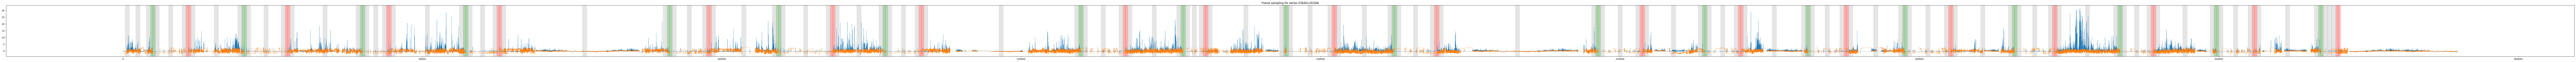

In [24]:
def display_sampling(series_id: str):
    series = series_map[series_id]
    events = event_map[series_id]
    plt.figure(figsize=(200, 4))
    plt.title(f'Frame sampling for series {series_id}')

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_color = 'green' if type == 'onset' else 'red'
        plt.axvline(step, color=event_color, lw=0.5)

        event_samples = sample_around(step)
        for frame_start, frame_end in event_samples:
            plt.axvspan(frame_start, frame_end, color=event_color, alpha=0.05)

        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                if frame_start < 0 or frame_end >= series.shape[0]:
                    continue
                plt.axvspan(frame_start, frame_end, color='black', alpha=0.1)
        last_event_step = step
    plt.plot(series, lw=0.5)

if not is_submission:
    display_sampling(series_list[0])

As seen on the image, we take `EVENT_SAMPLE_FRAMES` frames of training data around events for onset and wakeup, and the same number of frames between events.

Each gray bar represents a none event frame, while red lines and bars depict wakeup events and their frames, respectively. Onset events are symbolized by green lines, accompanied by green bars denoting their frames.

#### Executing the sampling

- `X_none`: sampled none frames (where no event occurs)
- `X_onset`: sampled onset frames
- `X_onset_time`: step of the onset event relative to the start of the frame
- `X_wakeup`: sampled wakeup frames
- `X_wakeup_time`: step of the wakeup event relative to the start of the frame

In [71]:
X_none = []
X_onset = []
X_onset_time = []
X_wakeup = []
X_wakeup_time = []
for series_id, events in event_map.items():
    series = series_map[series_id]

    last_event_step = 0
    for i in range(len(events)):
        step = events['step'][i]
        type = events['event'][i]

        event_samples = sample_around(step)
        for frame_start, frame_end in event_samples:
            if frame_start < 0 or frame_end >= series.shape[0]:
                continue
            if type == 'onset':
                X_onset.append(series[frame_start:frame_end])
                X_onset_time.append(step - frame_start)
            if type == 'wakeup':
                X_wakeup.append(series[frame_start:frame_end])
                X_wakeup_time.append(step - frame_start)
        if step - last_event_step >= MIN_NONE_SAMPLE_INTERVAL:
            n_samples = len(event_samples) // 2
            for frame_start, frame_end in sample_between(last_event_step, step, n_samples):
                if frame_start < 0 or frame_end >= series.shape[0]:
                    continue
                X_none.append(series[frame_start:frame_end])
        last_event_step = step

#### Visualization of the samples

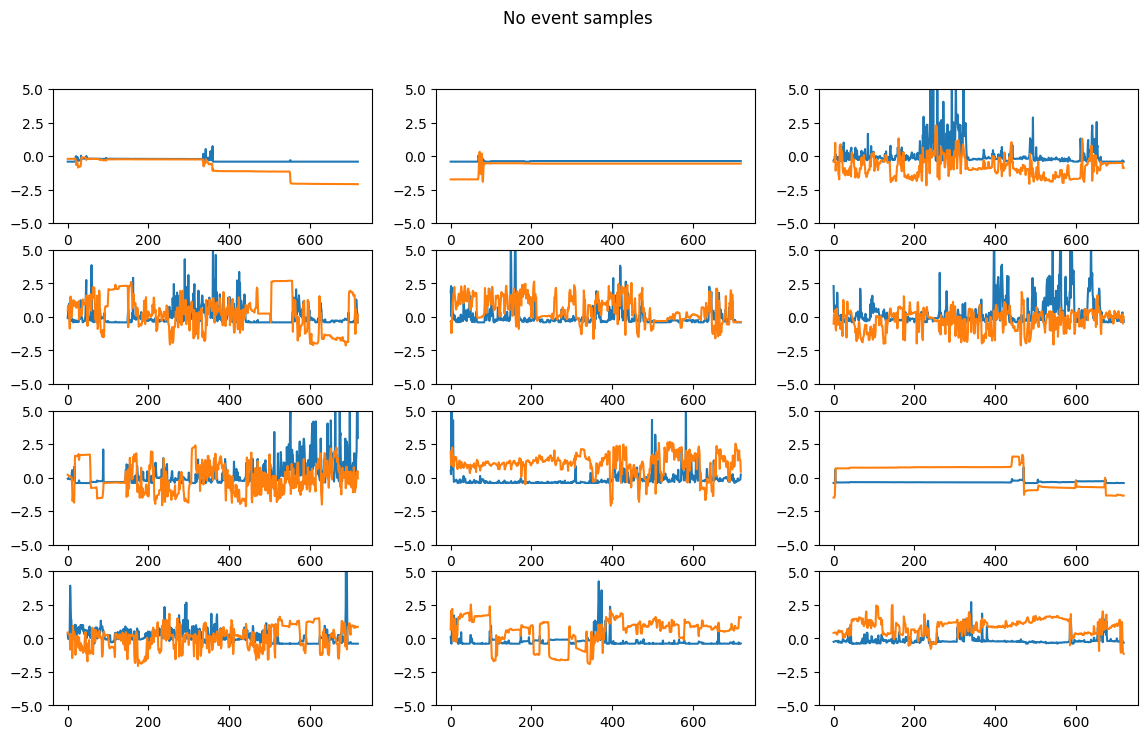

In [72]:
def plot_none_samples(samples):
    cols = 3
    rows = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].plot(samples[j * rows + i])
            ax[i][j].set_ylim(-5, 5)
    plt.suptitle('No event samples')
    #plt.tight_layout()
    plt.show()

if not is_submission:
    plot_none_samples(random.sample(X_none, 12))

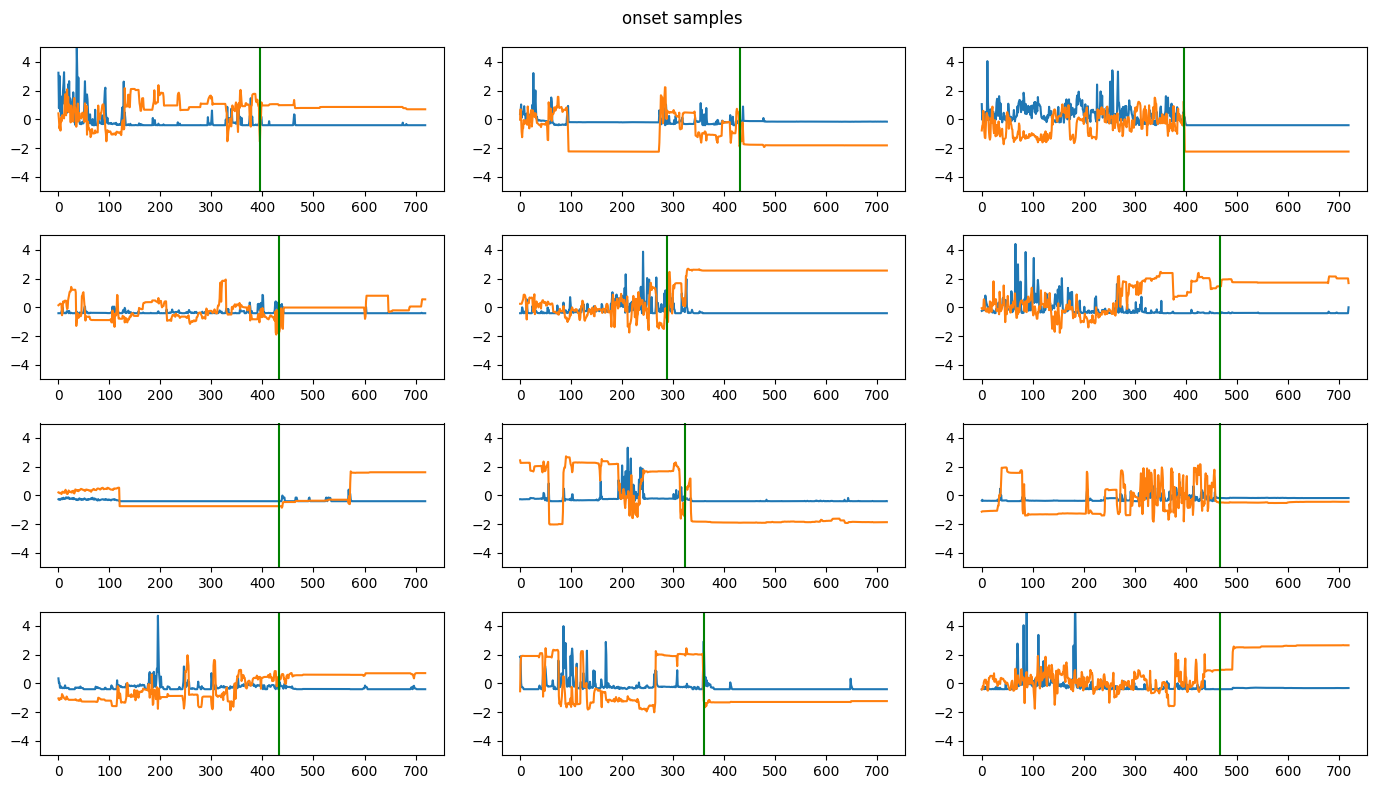

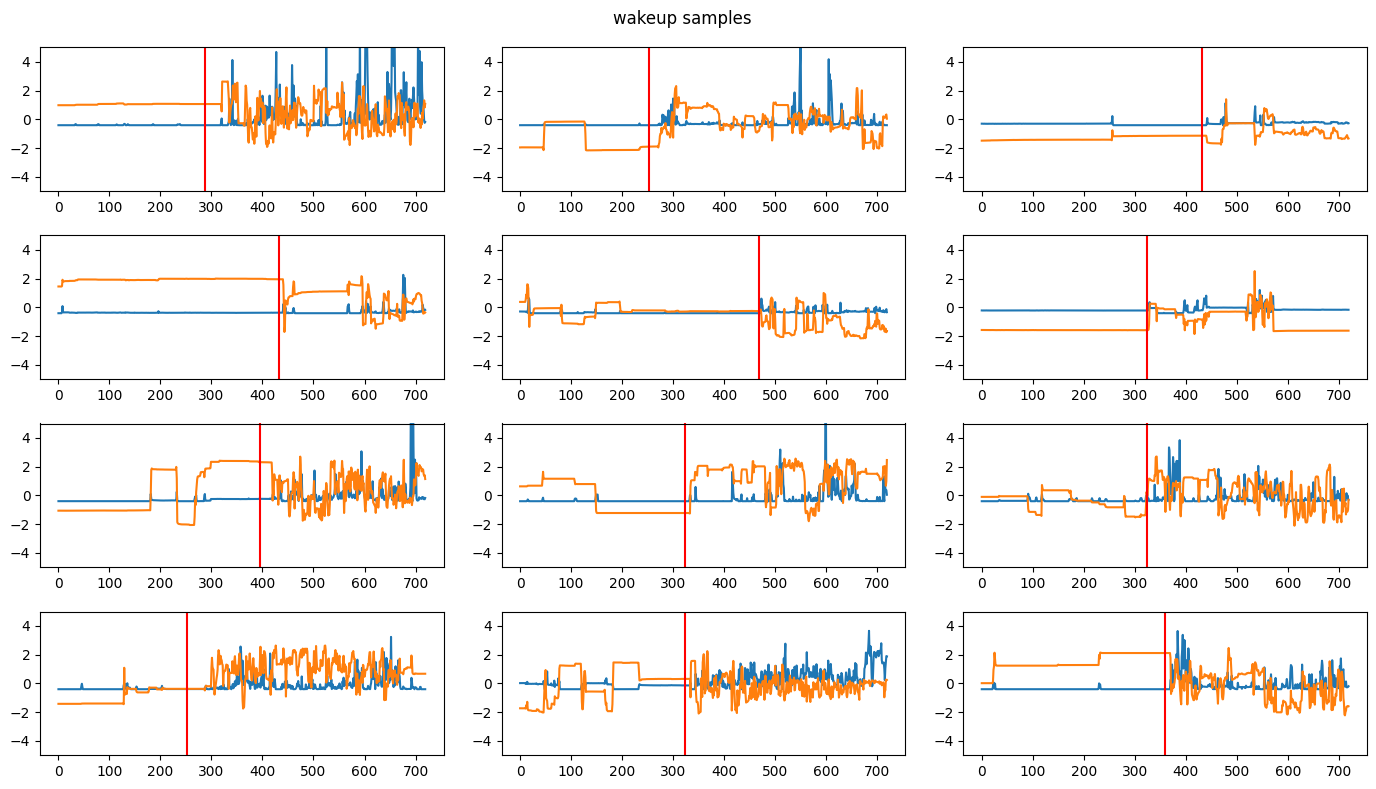

In [73]:
def plot_event_samples(type, samples: list[tuple], color: str):
    cols = 3
    rows = 4
    _, ax = plt.subplots(rows, cols, figsize=(14, 8))
    for i in range(rows):
        for j in range(cols):
            sample = samples[j * rows + i]
            ax[i][j].plot(sample[0])
            ax[i][j].axvline(sample[1], c=color)
            ax[i][j].set_ylim(-5, 5)
    plt.suptitle(f'{type} samples')
    plt.tight_layout()
    plt.show()

if not is_submission:
    plot_event_samples('onset', random.sample(list(zip(X_onset, X_onset_time)), 12), 'green')
    plot_event_samples('wakeup', random.sample(list(zip(X_wakeup, X_wakeup_time)), 12), 'red')

Green line is the step of the onset event.
Red line is the step of the wakeup event.


### Assembling the dataset
- `X`: input, with the dimensions (n_samples, frame_size, n_features)
- `Y`: labels, one-hot encoded categories, 0: none, 1: onset, 2: wakeup

In [74]:
n_class = min(len(X_none), len(X_onset), len(X_wakeup))
X_none = random.sample(X_none, n_class)
X_onset = random.sample(X_onset, n_class)
X_wakeup = random.sample(X_wakeup, n_class)

In [75]:
n_samples = len(X_none) + len(X_onset) + len(X_wakeup)
n_features = 2

X = np.empty([n_samples, FRAME_SIZE, n_features], dtype=np.float32)
Y = np.zeros([n_samples, 3], dtype=np.float32)

idx = 0
def fill_data(x, y_idx):
    global idx
    n = len(x)
    X[idx:idx + n] = x
    Y[idx:idx + n, y_idx] = 1.0
    idx += n

fill_data(X_none, 0)
fill_data(X_onset, 1)
fill_data(X_wakeup, 2)

In [76]:
print(X.shape)
print(Y.shape)

(74187, 720, 2)
(74187, 3)


#### Creating a test dataset for later evaluation
The test dataset's size is 5% of all training data.

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05)
print(len(X_train), len(Y_train))
print(len(X_test), len(Y_test))

70477 70477
3710 3710


## Model definition and training

### Model Definition

* Input Layer:
  * Conv1D(128, 4): Utilizes a 1-dimensional convolutional layer with 128 filters and a kernel size of 4. This layer applies a rectified linear unit (ReLU) activation function.
* Subsampling Layer:
  * MaxPooling1D(4): Performs max pooling with a pool size of 4. This layer reduces the dimensionality of the data by taking the maximum value over each 4-length subsequence.
* Convolutional Layer:
  * Conv1D(64, 4): Another 1D convolutional layer with 64 filters and a kernel size of 4. Like the previous convolutional layer, it applies the ReLU activation function.
* Flattening Layer:
  * Flatten(): Converts the output from the previous layer into a one-dimensional vector to prepare it for input into a fully connected layer.
* Dense Layers:
  * Dense(256, activation='relu'): A fully connected layer with 256 neurons using the ReLU activation function.
  * Dropout(0.4): Regularization technique to prevent overfitting by randomly dropping 40% of the connections during training.
  * Dense(128, activation='relu'): Another fully connected layer with 128 neurons and ReLU activation, followed by another dropout layer.
* Output Layer:
  * Dense(3, activation='softmax'): The final layer with 3 neurons and a softmax activation function, used for multi-class classification tasks. Softmax ensures that the output values represent probabilities for each class, and the class with the highest probability is chosen as the predicted class.

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definition
model = Sequential()
model.add(Conv1D(64, 4, activation='relu', input_shape=(FRAME_SIZE, n_features)))
model.add(MaxPooling1D(4))
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Conv1D(16, 4, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [79]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training
We use early stopping to prevent overfitting and saving the model with the best validation loss using `ModelCheckpoint`.

In [80]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint("model.hdf5", save_best_only=True)
network_history = model.fit(X_train, Y_train, epochs=20, validation_split=0.15, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
937/937 [==============================] - 8s 7ms/step - loss: 0.3067 - accuracy: 0.8986 - val_loss: 0.2312 - val_accuracy: 0.9302
Epoch 2/20
 19/937 [..............................] - ETA: 5s - loss: 0.2391 - accuracy: 0.9309

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


937/937 [==============================] - 7s 7ms/step - loss: 0.2328 - accuracy: 0.9279 - val_loss: 0.2516 - val_accuracy: 0.9169
Epoch 3/20
937/937 [==============================] - 6s 6ms/step - loss: 0.2215 - accuracy: 0.9306 - val_loss: 0.2369 - val_accuracy: 0.9286
Epoch 4/20
937/937 [==============================] - 8s 9ms/step - loss: 0.2091 - accuracy: 0.9337 - val_loss: 0.2127 - val_accuracy: 0.9319
Epoch 5/20
937/937 [==============================] - 6s 6ms/step - loss: 0.2028 - accuracy: 0.9354 - val_loss: 0.2110 - val_accuracy: 0.9340
Epoch 6/20
937/937 [==============================] - 7s 8ms/step - loss: 0.1968 - accuracy: 0.9378 - val_loss: 0.2079 - val_accuracy: 0.9334
Epoch 7/20
937/937 [==============================] - 6s 7ms/step - loss: 0.1863 - accuracy: 0.9404 - val_loss: 0.2128 - val_accuracy: 0.9335
Epoch 8/20
937/937 [==============================] - 7s 7ms/step - loss: 0.1847 - accuracy: 0.9402 - val_loss: 0.2084 - val_accuracy: 0.9311
Epoch 9/20
937/93

#### Training History

The plots below show how the accuracy and loss progresses as we train the network. The network quickly manages to learn the patterns and starts overfitting after the first one or two epochs.

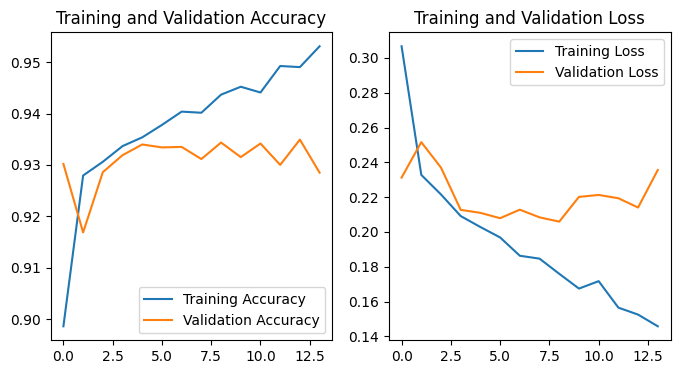

In [81]:
acc = network_history.history['accuracy']
val_acc = network_history.history['val_accuracy']

loss = network_history.history['loss']
val_loss = network_history.history['val_loss']

epochs_range = range(len(network_history.history['loss']))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Evaluation
First we evaluate the model on the test dataset we created from 5% of the total data, then we take 1 sample from each category and evaluate the model on those as an example.

In [82]:
from tensorflow.keras.models import load_model
model = load_model("model.hdf5")
test_err = model.evaluate(X_test,Y_test)
print(f"Test loss: {test_err[0]:.2}, Test accuracy: {test_err[1]:.2%}")

output = ['none', 'onset', 'wakeup']
print(output[np.argmax(model.predict(X[1].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[len(X)//2].reshape(1, -1 , 2)))])
print(output[np.argmax(model.predict(X[-1].reshape(1, -1 , 2)))])

116/116 [==============================] - 1s 4ms/step - loss: 0.1816 - accuracy: 0.9410
Test loss: 0.18, Test accuracy: 94.10%
1/1 [==============================] - 0s 97ms/step
none
1/1 [==============================] - 0s 17ms/step
onset
1/1 [==============================] - 0s 21ms/step
wakeup


In [83]:
X_none = None
X_train = None
X_wakeup = None
X_onset = None
gc.collect()

99110

## Prediction

Creating the predictions on the test dataset.

#### Importing and standardizing the test events

In [95]:
test_series = pd.read_parquet(path.join(data_root, 'test_series.parquet'), columns=['series_id', 'timestamp', 'anglez', 'enmo'])
test_series[['anglez', 'enmo']] = input_scaler.transform(test_series[['anglez', 'enmo']])

#### Constants

- `PRED_STRIDE` = The stride of the rolling window samples.
- `PRED_PROBABILITY_THRESHOLD` = Only consider events the model is x%+ confident about
- `PRED_MERGE_THRESHOLD` = Events have to be at least x minutes apart
- `MIDNIGHT_POINT` = step of midnight
- `EVENT_ONSET` = onset probability index in the one-hot encoded output vector
- `EVENT_WAKEUP` = wakeup probability index in the one-hot encoded output vector

In [84]:
PRED_STRIDE = 5 * 12
PRED_PROBABILITY_THRESHOLD = 0.97
PRED_MERGE_THRESHOLD = 20 * 12
MIDNIGHT_POINT = 2160

In [85]:
EVT_ONSET = 1
EVT_WAKEUP = 2

#### Functions used in prediction

In [86]:
def get_rolling_frames(series):
    n_frames = (series.shape[0] - FRAME_SIZE) // PRED_STRIDE + 1
    centers = np.empty([n_frames])
    frames = np.empty([n_frames, FRAME_SIZE, n_features])
    for idx, frame_start in enumerate(range(0, series.shape[0] - FRAME_SIZE + 1, PRED_STRIDE)):
        frames[idx] = series[frame_start:frame_start + FRAME_SIZE]
        centers[idx] = frame_start + FRAME_SIZE // 2
    return frames, centers

Slides a rolling window through the series with a given stride, returns a list of frames and a list of the corresponding center points of each frame.

In [87]:
def get_predicted_events(predictions, frame_centers, event_idx):
    predicted_events = []
    for idx, pred in enumerate(predictions):
        p = pred[event_idx] # predicted probability of event
        if p >= PRED_PROBABILITY_THRESHOLD:
            predicted_events.append(frame_centers[idx])
    return predicted_events

Returns a list of predicted events, which are the centers of frames where the predicted probability of the event type exceeds a threshold.

In [88]:
def combine_predictions(predictions):
    combined = []
    segment = []
    last = None
    for step in predictions:
        if last != None and step - last > PRED_MERGE_THRESHOLD:
            points = np.array(segment)
            combined.append(int(points.mean()))
            segment.clear()
        segment.append(step)
        last = step
    if segment != []:
        points = np.array(segment)
        combined.append(int(points.mean()))
    return combined

Combine multiple predicted events into one event if they happen within a given interval.

In [89]:
def merge_events(onsets, wakeups):
    merged_events = []
    merged_events.extend([(EVT_ONSET, step) for step in onsets])
    merged_events.extend([(EVT_WAKEUP, step) for step in wakeups])
    merged_events.sort(key=lambda event: event[1])
    return merged_events

Returns a merged list of onset and wakeup events.

In [113]:
def fit_sleep_periods(events):
    sleeps = []

    sleep_start = None
    sleep_end = None

    for event, step in events:
        if event == EVT_WAKEUP and sleep_start == None:
            continue
        if event == EVT_ONSET and sleep_start == None:
            sleep_start = step
        if event == EVT_WAKEUP and sleep_start != None:
            sleep_end = step
        if event == EVT_ONSET and sleep_end != None:
            sleeps.append((sleep_start, sleep_end))
            sleep_start = step
            sleep_end = None

    if sleep_end != None:
        sleeps.append((sleep_start, sleep_end))
    return sleeps

Receives a chronologically ordered list of events and combines them into onset and wakeup pairs, which make up the longest possible sleep periods.

In [91]:
def merge_sleeps(sleeps):
    new_sleeps = []
    last_wakeup = None
    sleep_start = None
    for onset, wakeup in sleeps:
        if last_wakeup is None:
            sleep_start = onset
        elif onset - last_wakeup >= 30 * 12:
            new_sleeps.append((sleep_start, last_wakeup))
            sleep_start = onset
        last_wakeup = wakeup
    if sleep_start is not None:
        new_sleeps.append((sleep_start, last_wakeup))
    return new_sleeps

Merges two sleep periods if the gap between them is shorter than 30 minutes.

In [92]:
def assign_to_nights(series_len, start_time, sleep_periods):
    n_nights = (series_len + start_time - MIDNIGHT_POINT) // (24 * 60 * 12) + 2
    sleeps_per_night = [[] for _ in range(0, n_nights)]
    for start, end in sleep_periods:
        mid = int((start + end) / 2)
        night_idx = (mid + start_time - MIDNIGHT_POINT + 12 * 60 * 12) // (24 * 60 * 12)
        sleeps_per_night[night_idx].append((start, end))
    return sleeps_per_night

Takes a list of sleep periods and the time of day of the first timestep (steps between midnight and the first timestep). Assigns each sleep period to a night based on which day's `MIDNIGHT_POINT` is the middle of the sleep period is the it closest to. Returns a list of sleep periods for each night.

In [93]:
def filter_max_sleeps(sleeps_nights):
    return [ max(sleeps, key=lambda sleep: sleep[1] - sleep[0]) for sleeps in sleeps_nights if sleeps != []]

Returns a list of the longest sleep period of each night.

In [94]:
def filter_short_sleeps(sleeps):
    return [ (onset, wakeup) for onset, wakeup in sleeps if wakeup - onset >= 30 * 12 ]

If the sleep period is shorter than 30 minutes filter it out as it's invalid as per the rules.

#### Visualization of prediction

In [96]:
if not is_submission:
    test_events = pd.read_csv(path.join(data_root, 'test_events.csv'))

In [129]:
def plot_events(series, onset_events, wakeup_events):
    plt.figure(figsize=(200, 4))
    plt.ylim(-5, 20)
    plt.xticks(range(0,series.shape[0], 8640))
    for step in onset_events:
        plt.axvline(step, color='green')
    for step in wakeup_events:
        plt.axvline(step, color='red')
    plt.plot(series, lw=0.5)

In [109]:
def plot_sleep_periods(series, sleeps):
    plt.figure(figsize=(200, 4))
    plt.xticks(range(0,series.shape[0], 8640))
    for sleep in sleeps:
        plt.axvspan(sleep[0], sleep[1], color='green', alpha=0.3)
    plt.plot(series, lw=0.5)
    pass

* Event plots:
Each green line represents a predicted onset event and each red line represents a wakeup event.
* Sleep period plots:
Each green interval represents a predicted sleep period.

In [125]:
if not is_submission:
    events = test_events[test_events['series_id'] == '4b45c36f8f5a']
    events = events.dropna(axis=0)
    events = events.reset_index(drop=True)
    series = test_series[test_series['series_id'] == '4b45c36f8f5a']
    series = series[['enmo', 'anglez']].to_numpy()

    sleeps_actual = [tuple(e['step']) for night, e in events.groupby('night')]

    onsets_actual = events[events['event'] == 'onset']['step'].to_numpy(dtype=np.int32)
    wakeups_actual = events[events['event'] == 'wakeup']['step'].to_numpy(dtype=np.int32)

    prediction_frames, centers = get_rolling_frames(series)
    predictions = model.predict(prediction_frames)

    onsets_predicted = get_predicted_events(predictions, centers, EVT_ONSET)
    wakeups_predicted = get_predicted_events(predictions, centers, EVT_WAKEUP)

198/198 [==============================] - 0s 2ms/step


Ground-truth events vs predictions:

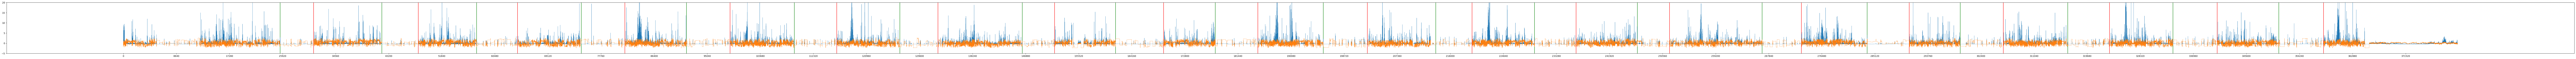

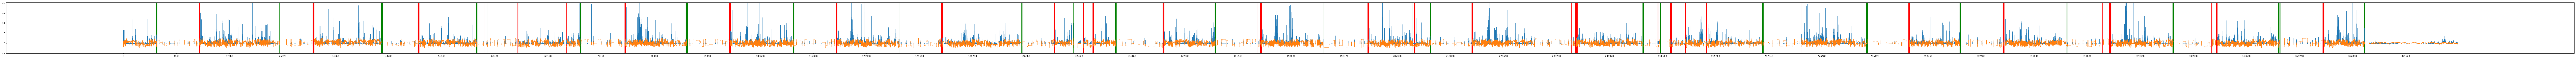

In [130]:
if not is_submission:
    plot_events(series, onsets_actual, wakeups_actual)
    plot_events(series, onsets_predicted, wakeups_predicted)

Combined events:

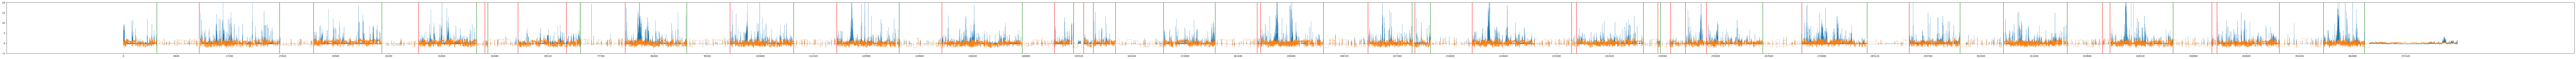

In [131]:
if not is_submission:
    onsets_prediced = combine_predictions(onsets_predicted)
    wakeups_predicted = combine_predictions(wakeups_predicted)
    plot_events(series, onsets_prediced, wakeups_predicted)

Fitted sleep periods:

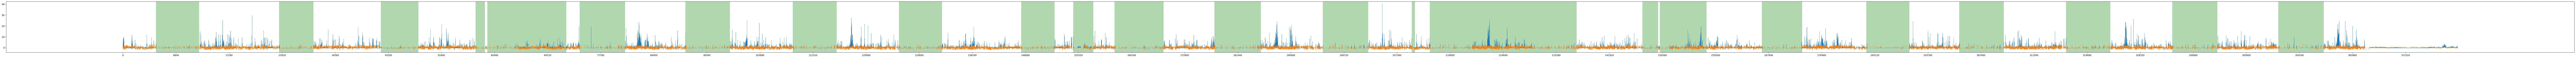

In [132]:
if not is_submission:
    sleeps_predicted = fit_sleep_periods(merge_events(onsets_predicted, wakeups_predicted))
    plot_sleep_periods(series, sleeps_predicted)

Merged and filtered sleep periods:

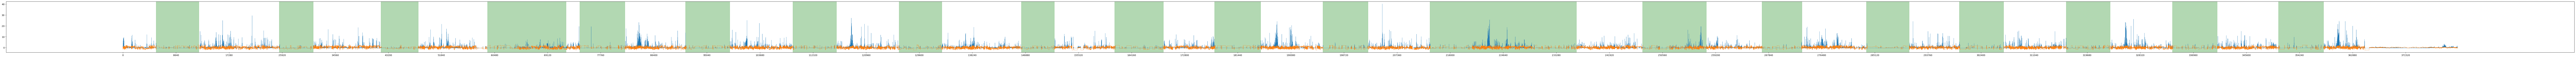

In [135]:
if not is_submission:
    sleeps_predicted = filter_short_sleeps(sleeps_predicted)
    sleeps_predicted = merge_sleeps(sleeps_predicted)
    sleeps_filtered = filter_max_sleeps(assign_to_nights(len(series), 6120 + 3 * 60 * 12, sleeps_predicted))
    plot_sleep_periods(series, sleeps_filtered)

Final sleep period predictions vs ground truth sleep periods:

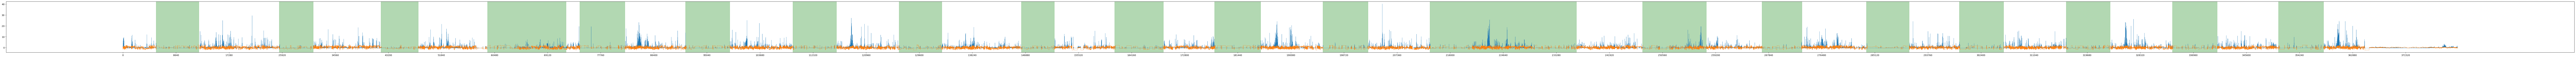

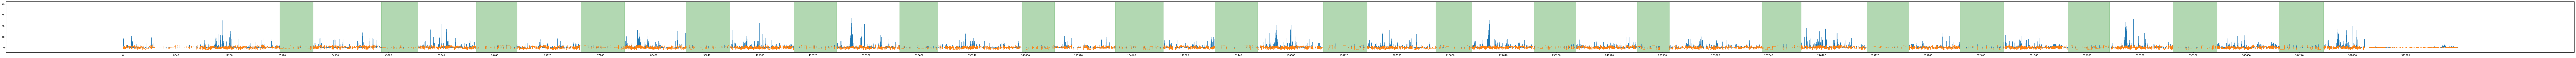

In [133]:
if not is_submission:
    plot_sleep_periods(series, sleeps_filtered)
    plot_sleep_periods(series, sleeps_actual)

#### Prediction of test series and creating a submission dataframe

In [136]:
def predict_sleep_periods(series: np.ndarray, start_time) -> list[tuple[int]]:
    prediction_frames, centers = get_rolling_frames(series)
    predictions = model.predict(prediction_frames)

    onsets_predicted = get_predicted_events(predictions, centers, EVT_ONSET)
    wakeups_predicted = get_predicted_events(predictions, centers, EVT_WAKEUP)

    onsets_predicted = combine_predictions(onsets_predicted)
    wakeups_predicted = combine_predictions(wakeups_predicted)

    sleeps_predicted = fit_sleep_periods(merge_events(onsets_predicted, wakeups_predicted))

    sleeps_predicted = filter_short_sleeps(sleeps_predicted)
    sleeps_predicted = merge_sleeps(sleeps_predicted)

    sleeps_filtered = filter_max_sleeps(assign_to_nights(len(series), start_time, sleeps_predicted))
    sleeps_filtered = filter_short_sleeps(sleeps_filtered)
    return sleeps_filtered

For each series indicated by series_id, predict each event occurring in that series by giving the event type and the step where the event occurred as well as a confidence score for that event. The evaluation metric additionally requires a row_id with an enumeration of events.

In [137]:
def create_submission_df(series_id, sleeps):
    submission = None
    for onset, wakeup in sleeps:
        sleep_df = pd.DataFrame([
            {'series_id': series_id, 'step': onset, 'event': 'onset', 'score': 1.0},
            {'series_id': series_id, 'step': wakeup, 'event': 'wakeup', 'score': 1.0}
        ])
        if submission is None:
            submission = sleep_df
        else:
            submission = pd.concat([submission, sleep_df], ignore_index=True)
    return submission

In [138]:
from datetime import datetime

submission = None
for series_id, s in test_series.groupby('series_id'):
    series = s.reset_index(drop=True)
    if (len(series) < FRAME_SIZE):
        continue
    first_timestamp = series['timestamp'][0]
    first_timestamp = datetime.strptime(first_timestamp[:-5], '%Y-%m-%dT%H:%M:%S')
    first_step_time = (first_timestamp.hour * 3600 + first_timestamp.minute * 60 + first_timestamp.second) // 5
    series_data = series[['enmo', 'anglez']].reset_index(drop=True).to_numpy()
    sleeps = predict_sleep_periods(series_data, first_step_time)
    sleeps_df = create_submission_df(series_id, sleeps)
    if submission is None:
        submission = sleeps_df
    else:
        submission = pd.concat([submission, sleeps_df], ignore_index=True)

210/210 [==============================] - 0s 2ms/step


## Evaluation using Event Detection AP

### Scoring function

The following code is the evaluation metric provided by Kaggle which is used to score submissions.

Source:
https://www.kaggle.com/code/metric/event-detection-ap

In [ ]:
from typing import Dict, List, Tuple


class ParticipantVisibleError(Exception):
    pass


# Set some placeholders for global parameters
series_id_column_name = None
time_column_name = None
event_column_name = None
score_column_name = None
use_scoring_intervals = None


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    tolerances: Dict[str, List[float]],
    series_id_column_name: str,
    time_column_name: str,
    event_column_name: str,
    score_column_name: str,
    use_scoring_intervals: bool = False,
) -> float:
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference(
        {"start", "end"}
    ), (
        f"Solution column {event_column_name} must contain the same events "
        "as defined in tolerances."
    )
    assert pd.api.types.is_numeric_dtype(
        solution[time_column_name]
    ), f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(
                f"Submission must have column '{target_name}'."
            )

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()["series_id_column_name"] = series_id_column_name
    globals()["time_column_name"] = time_column_name
    globals()["event_column_name"] = event_column_name
    globals()["score_column_name"] = score_column_name
    globals()["use_scoring_intervals"] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)


def filter_detections(
    detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
    tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
    detections_sorted = detections.sort_values(
        score_column_name, ascending=False
    ).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted["matched"] = is_matched

    return detections_sorted


def precision_recall_curve(
    matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind="stable")[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = (
        tps / p
    )  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    tolerances: Dict[str, List[float]],
) -> float:
    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution.query("event in ['start', 'end']")
            .assign(
                interval=lambda x: x.groupby(
                    [series_id_column_name, event_column_name]
                ).cumcount()
            )
            .pivot(
                index="interval",
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ["start", "end"]]
            .apply(lambda x: pd.Interval(*x, closed="both"), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = solution.query("event not in ['start', 'end']").reset_index(
        drop=True
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched=False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name),
            intervals.groupby(series_id_column_name),
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [
            (ev, tol, vid)
            for ev in tolerances.keys()
            for tol in tolerances[ev]
            for vid in ground_truths[series_id_column_name].unique()
        ],
        columns=[event_column_name, "tolerance", series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = aggregation_keys.merge(
        detections_filtered, on=[event_column_name, series_id_column_name], how="left"
    ).groupby([event_column_name, "tolerance", series_id_column_name])
    ground_truths_grouped = aggregation_keys.merge(
        ground_truths, on=[event_column_name, series_id_column_name], how="left"
    ).groupby([event_column_name, "tolerance", series_id_column_name])
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets["tolerance"].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched.query("event in @event_classes")
        .groupby([event_column_name, "tolerance"])
        .apply(
            lambda group: average_precision_score(
                group["matched"].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

### Scoring the submission

In [142]:
if not is_submission:
    tolerances = {"onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
             "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
    print(score(test_events, submission, tolerances, "series_id", "step", "event", "score"))

0.29464928582233074


## Writing submission

Write the submission file if running as submission.

In [140]:
display(submission)

series_id    step   event  score
0     05e1944c3818    3000   onset    1.0
1     05e1944c3818    9870  wakeup    1.0
2     05e1944c3818   20520   onset    1.0
3     05e1944c3818   27380  wakeup    1.0
4     05e1944c3818   38310   onset    1.0
...            ...     ...     ...    ...
1197  f88e18cb4100  340590  wakeup    1.0
1198  f88e18cb4100  349920   onset    1.0
1199  f88e18cb4100  360540  wakeup    1.0
1200  f88e18cb4100  370500   onset    1.0
1201  f88e18cb4100  374760  wakeup    1.0

[1202 rows x 4 columns]

In [141]:
if is_submission:
    if submission is not None:
        submission.to_csv('submission.csv', index_label='row_id')
    else:
        !touch submission.csv